<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/10_7_Encoder_Decoder_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.8 MB/s eta 0:00:00


## 10.7 Encoder-Decoder Seq2Seq for Machine Translation

In [2]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 10.7.2 Encoding

In [3]:
def init_seq2seq(module):
  """Initialize weights for Seq2Seq."""
  if type(module) == nn.Linear:
    nn.init.xavier_uniform_(module.weight)
  if type(module) == nn.GRU:
    for param in module._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform(module._parameters[param])

In [4]:
class Seq2SeqEncoder(d2l.Encoder):
  """The RNN encoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
               dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
    self.apply(init_seq2seq)

  def forward(self, X, *args):
    # X shape: (batch_size, num_steps)
    embs = self.embedding(X.t().type(torch.int64))
    outputs, state = self.rnn(embs)
    return outputs, state

In [5]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9

encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)

d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

<ipython-input-3-13dda837ebc2>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(module._parameters[param])


In [6]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

### 10.7.3 Decoder

In [7]:
class Seq2SeqDecoder(d2l.Decoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
               dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, 
                       num_layers, dropout)
    self.dense = nn.LazyLinear(vocab_size)
    self.apply(init_seq2seq)

  def init_state(self, enc_all_outputs, *args):
    return enc_all_outputs

  def forward(self, X, state):                                                   # X shape: (batch_size, num_steps)
    embs = self.embedding(X.t().type(torch.int32))                               # embs shape: (num_steps, batch_size, embed_size)
    enc_output, hidden_state = state
    context = enc_output[-1]                                                     # context shape: (batch_size, num_hiddens)
    context = context.repeat(embs.shape[0], 1, 1)                                # Broadcast context to (num_steps, batch_size, num_hiddens)
    embs_and_context = torch.cat((embs, context), -1)                            # concat at the feature dimension
    outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
    outputs = self.dense(outputs).swapaxes(0, 1)
    return outputs, [enc_output, hidden_state]                                   # output shape: (batch_size, num_steps, vocab_size)
                                                                                 # hidden_state shape: (num_layers, batch_size, num_hiddens)

In [8]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
<ipython-input-3-13dda837ebc2>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(module._parameters[param])


### 10.7.4 Encoder-Decoder for Sequence to Sequence Learning

In [9]:
class Seq2Seq(d2l.EncoderDecoder):
  def __init__(self, encoder, decoder, tgt_pad, lr):
    super().__init__(encoder, decoder)
    self.save_hyperparameters()

  def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

### 10.7.5 Loss Function with Masking

In [10]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
  l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
  mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
  return (l * mask).sum() / mask.sum()

### 10.7.6 Training

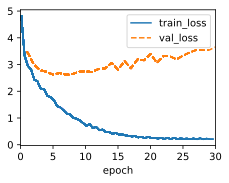

In [11]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens,
                         num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens,
                         num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 10.7.7 Prediction

In [12]:
@d2l.add_to_class(d2l.EncoderDecoder)
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
  batch = [a.to(device) for a in batch]
  src, tgt, src_valid_len, _ = batch
  enc_all_outputs = self.encoder(src, src_valid_len)
  dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
  outputs, attention_wieghts = [tgt[:, 0].unsqueeze(1), ], []
  for _ in range(num_steps):
    Y, dec_state = self.decoder(outputs[-1], dec_state)
    outputs.append(Y.argmax(2))
    if save_attention_weights:
      attention_wieghts.append(self.decoder.attention_weights)
  return torch.cat(outputs[1:], 1), attention_wieghts

### 10.7.8 Evaluation of Predicted Sequences

In [13]:
def bleu(pred_seq, label_seq, k):
  pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
  len_pred, len_label = len(pred_tokens), len(label_tokens)
  score = math.exp(min(0, 1 - len_label / len_pred))
  for n in range(1, min(k, len_pred) + 1):
    num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label -n + 1):
      label_subs[' '.join(label_tokens[i: i+n])] +=1
    for i in range(len_pred -n + 1):
      if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
        num_matches +=1
        label_subs[' '.join(pred_tokens[i: i + n])] -=1
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
  return score

In [15]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
  translation = []
  for token in data.tgt_vocab.to_tokens(p):
    if token == '<eos>':
      break
    translation.append(token)
  print(f'{en} => {translation}, bleu,'
        f'{bleu(" ".join(translation), fr, k=2): 0.3f}')

go . => ['va', '!'], bleu, 1.000
i lost . => ["j'ai", 'perdu', '.'], bleu, 1.000
he's calm . => ['nous', '<unk>', '.'], bleu, 0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu, 1.000
